# Import Dependencies

In [1678]:
# System
import os

# Data Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf

import csv
import pickle

# Get Data

In [1679]:
random_state = np.random.randint(0, 10000)
random_state

5676

In [1680]:
file_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/cutfree-simulations/runtime_data_v2.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()
df.iloc[0]

Oligo                        NNNNNN
OligoLength                       6
Sites                   Any["YATR"]
TotalSites                        1
SiteLength                        4
CutFree_Randomer             NBNVVN
CutFree_Degeneracy          7.45472
CutFree_Time               0.006211
CutFreeRL_Randomer           NNVVVN
CutFreeRL_Degeneracy        7.45472
CutFreeRL_Time             0.228063
Name: 0, dtype: object

In [1681]:
conditions = [
    (df["CutFree_Time"] > 60),
    (df["CutFree_Time"] <= 60)
]

values = [0, 1] # 0 = Reject, 1 = Accept

df["Allow"] = np.select(conditions, values)

# Rejection Sampling

In [1682]:
numCutFree = df[df.Allow == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Allow == 1].shape[0]
print(numCutFreeRL)

563
4686


In [1683]:
df_rejection = df[df.Allow == 1].sample(int((numCutFreeRL-numCutFree)+(numCutFree/4)), random_state=random_state)
df = df.drop(df_rejection.index)

In [1684]:
numCutFree = df[df.Allow == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Allow == 1].shape[0]
print(numCutFreeRL)

563
423


In [1685]:
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]

values = [0, 1] # 0 = CutFree, 1 = CutFreeRL

df_total = df.copy()

df_total["Algorithm"] = np.select(conditions, values)

In [1686]:
df = df[["OligoLength", "TotalSites", "SiteLength", "Allow"]]
df

,OligoLength,TotalSites,SiteLength,Allow
6,6,7,4,1
9,6,10,4,1
18,6,9,5,1
22,6,3,6,1
36,6,7,7,1
...,...,...,...,...
5243,40,5,8,0
5245,40,7,8,0
5246,40,8,8,0
5247,40,9,8,0


# Visualize Data

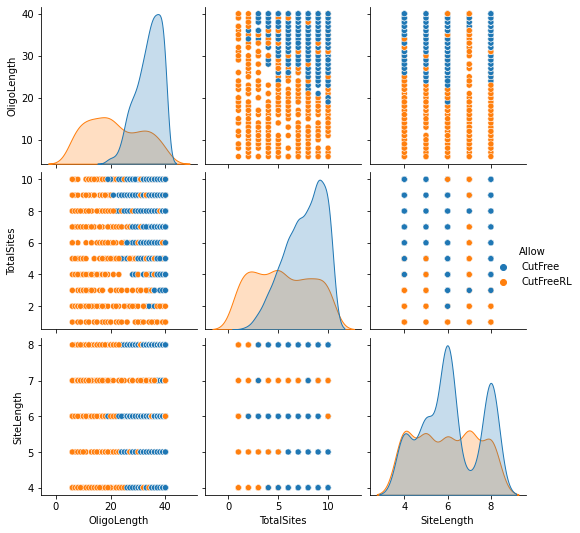

In [1687]:
pair_plot = sns.pairplot(df, hue="Allow", diag_kind="kde")
new_labels = ["CutFree", "CutFreeRL"]
for t, l in zip(pair_plot._legend.texts, new_labels):
    t.set_text(l)
plt.show(pair_plot)

# Get Train/Test Split

In [1688]:
x = df.drop(["Allow"], axis=1)
y = df["Allow"]

In [1689]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x, y, test_size=0.2, random_state=random_state)
x_train_df.head()

,OligoLength,TotalSites,SiteLength
3499,40,10,8
1326,32,7,6
2994,30,5,8
4631,28,2,7
3918,14,9,5


In [1690]:
y_train_df.head()

3499    0
1326    0
2994    0
4631    1
3918    1
Name: Allow, dtype: int32

In [1691]:
x_train, y_train = tf.convert_to_tensor(x_train_df, dtype=tf.float32), tf.convert_to_tensor(y_train_df, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test_df, dtype=tf.float32), tf.convert_to_tensor(y_test_df, dtype=tf.float32)

In [1692]:
x_train

<tf.Tensor: shape=(788, 3), dtype=float32, numpy=
array([[40., 10.,  8.],
       [32.,  7.,  6.],
       [30.,  5.,  8.],
       ...,
       [37.,  6.,  6.],
       [36.,  5.,  8.],
       [21., 10.,  8.]], dtype=float32)>

# Machine Learning

In [1693]:
def get_accuracy(pred, true):
    test_accuracy = accuracy_score(pred, true)*100
    print("Accuracy: {:.2f}%".format(test_accuracy))
    return test_accuracy

### MLP Classifier NN

In [1694]:
class_NN = MLPClassifier(
    hidden_layer_sizes= (32, 16),
    activation='relu',
    solver='sgd',
    momentum=0.99,
    alpha=0.0005,
    learning_rate='adaptive',
    max_iter=2000, 
    verbose=0,
    random_state=random_state)
class_NN.fit(x_train, y_train)

MLPClassifier(alpha=0.0005, hidden_layer_sizes=(32, 16),
              learning_rate='adaptive', max_iter=2000, momentum=0.99,
              random_state=5676, solver='sgd', verbose=0)

In [1695]:
y_pred_mlp = class_NN.predict(x_test)
mlp_acc = get_accuracy(y_pred_mlp, y_test)

Accuracy: 86.36%


In [1696]:
params = {
    #'hidden_layer_sizes' : [###(32, 16), (32, 16, 8)],
    #'activation' : [###'tanh', 'relu'],
    #'solver' : [###'adam', 'sgd']
    #'alpha' : [0.00001, 0.0001, ###0.0005, 0.001],
    #'momentum' : [0.555, 0.785, 0.795, 0.805, 0.815],
}

gscv = GridSearchCV(class_NN, params, verbose=1)

# gscv.fit(np.array(x_train), np.array(y_train))
# print(gscv.best_params_)

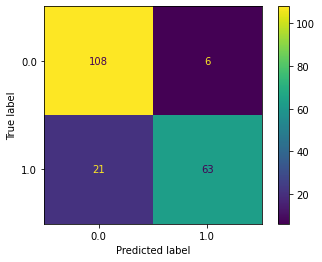

In [1697]:
plot_confusion_matrix(class_NN, x_test, y_test)  
plt.show()

In [1698]:
print(classification_report(y_pred_mlp, y_test, target_names=["Reject", "Accept"]))

              precision    recall  f1-score   support

      Reject       0.95      0.84      0.89       129
      Accept       0.75      0.91      0.82        69

    accuracy                           0.86       198
   macro avg       0.85      0.88      0.86       198
weighted avg       0.88      0.86      0.87       198



### K-Nearest Neighbors Classifier

In [1699]:
neigh = KNeighborsClassifier(n_neighbors=3, weights='distance')
neigh.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [1700]:
y_pred_neigh = neigh.predict(x_test)
neigh_acc = get_accuracy(y_pred_neigh, y_test)

Accuracy: 87.37%


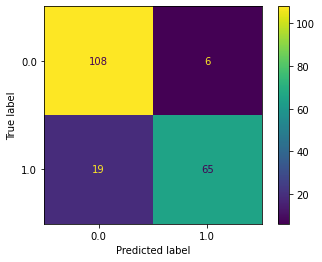

In [1701]:
plot_confusion_matrix(neigh, x_test, y_test)  
plt.show()

### Random Forest

In [1702]:
clf = RandomForestClassifier(
    criterion='gini',
    max_depth=7,
    random_state=random_state)
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=7, random_state=5676)

In [1703]:
y_pred_clf = clf.predict(x_test)
clf_acc = get_accuracy(y_pred_clf, y_test)

Accuracy: 90.40%


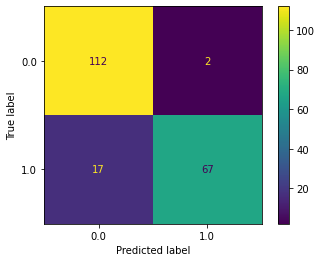

In [1704]:
plot_confusion_matrix(clf, x_test, y_test)  
plt.show()

### Support Vector Machine

In [1705]:
svc = svm.SVC(
    kernel='rbf',
    C=1,
    gamma='auto',
    random_state=random_state
)
svc.fit(x_train, y_train)

SVC(C=1, gamma='auto', random_state=5676)

In [1706]:
y_pred_svc = svc.predict(x_test)
svc_acc = get_accuracy(y_pred_svc, y_test)

Accuracy: 88.89%


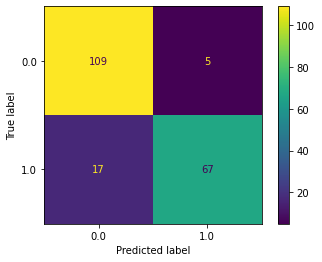

In [1707]:
plot_confusion_matrix(svc, x_test, y_test)  
plt.show()

In [1708]:
params = {
    #'n_neighbors' : [3, 5, 7, 9, 11, 13, 15],
    #'weights' : ['uniform', 'distance'],
    #'algorithm' : [###'auto', 'ball_tree', 'kd_tree', 'brute'],
}

gscv = GridSearchCV(neigh, params, verbose=1)

# gscv.fit(np.array(x_train), np.array(y_train))
# print(gscv.best_params_)

# Visualize Data for K-Nearest Neighbors

In [1709]:
df_total = df_total[["OligoLength", "TotalSites", "SiteLength", "Allow", "CutFree_Time", "Algorithm"]]
df_total.head()

,OligoLength,TotalSites,SiteLength,Allow,CutFree_Time,Algorithm
6,6,7,4,1,0.018870,0
9,6,10,4,1,0.021175,0
18,6,9,5,1,0.011264,0
22,6,3,6,1,0.008601,0
36,6,7,7,1,0.007328,0


In [1710]:
df_total = df_total.sort_values(by=["CutFree_Time"], ascending=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Allow,CutFree_Time,Algorithm
91,7,2,8,1,0.004833,0
1841,7,2,8,1,0.006972,0
3630,8,1,7,1,0.007041,0
3520,6,1,6,1,0.007317,0
36,6,7,7,1,0.007328,0


In [1711]:
df_total.loc[x_test_df.index[np.where(y_test_df != y_pred_neigh)], "Prediction"] = 0
df_total.loc[df_total["Prediction"].isna(), "Prediction"] = 1

In [1712]:
df_total = df_total.reset_index(drop=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Allow,CutFree_Time,Algorithm,Prediction
0,7,2,8,1,0.004833,0,1.0
1,7,2,8,1,0.006972,0,1.0
2,8,1,7,1,0.007041,0,1.0
3,6,1,6,1,0.007317,0,1.0
4,6,7,7,1,0.007328,0,1.0


In [1713]:
gfont = {'fontname':'Georgia'}
font = font_manager.FontProperties(family='Georgia', style='normal', size=32)

In [1714]:
df_total = df_total[df_total.Algorithm == 1]

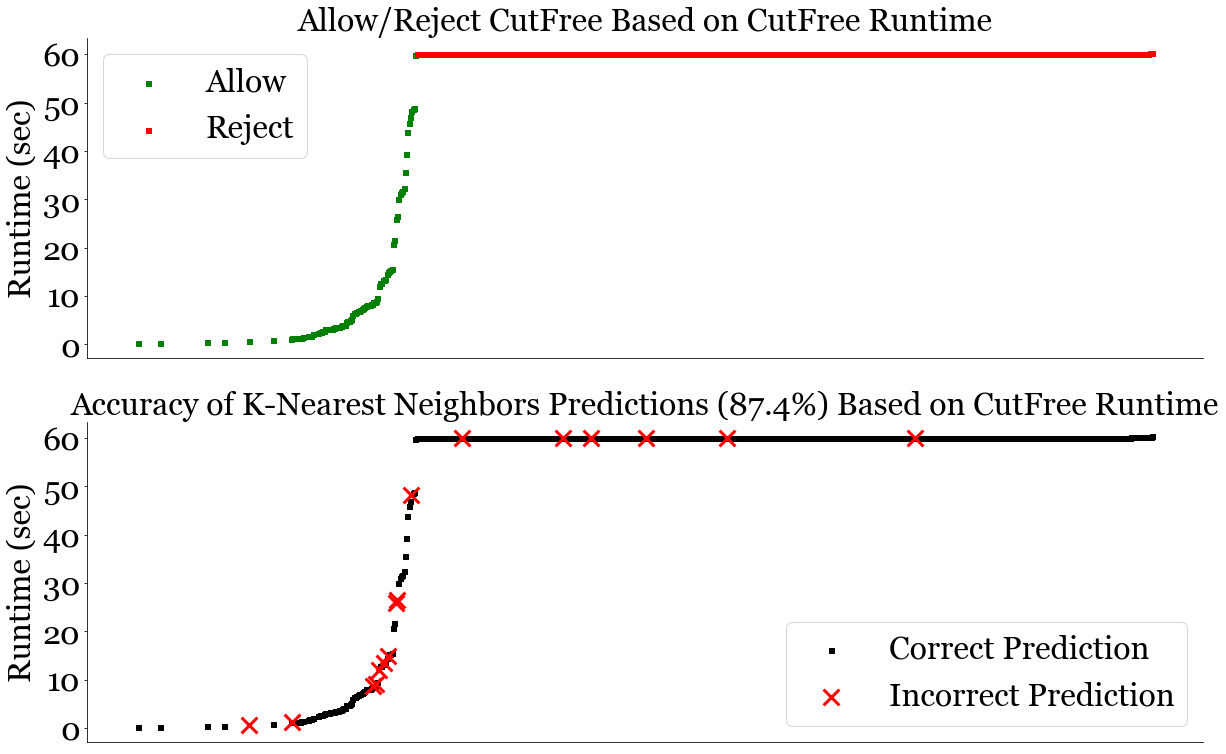

In [1715]:
plt.figure(figsize=(20,20))

plt.subplot(311)

plt.scatter(
    df_total[df_total.Allow==1].index, df_total[df_total.Allow==1].CutFree_Time, 
    c ="green",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Allow==0].index, df_total[df_total.Allow==0].CutFree_Time, 
    c ="red",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.title("Allow/Reject CutFree Based on CutFree Runtime", fontsize=32, **gfont)
plt.ylabel("Runtime (sec)", fontsize=32, **gfont)
plt.legend(["Allow", "Reject"], prop=font, loc="upper left")
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.subplot(312)
plt.scatter(
    df_total[df_total.Prediction==1].index, df_total[df_total.Prediction==1].CutFree_Time, 
    c ="black",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Prediction==0].index, df_total[df_total.Prediction==0].CutFree_Time, 
    c ="red",
    linewidths = 3,
    marker ="x",
    s = 250)

plt.title(f"Accuracy of K-Nearest Neighbors Predictions ({neigh_acc:.1f}%) Based on CutFree Runtime", fontsize=32, **gfont)
plt.ylabel("Runtime (sec)", fontsize=32, **gfont)
plt.legend(["Correct Prediction", "Incorrect Prediction"], prop=font)
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Get Results

In [1716]:
false_positives = df_total[df_total.Prediction==0].CutFree_Time > 60
false_positives = false_positives[false_positives==True].count()

true_positives = df_total[df_total.Prediction==1].CutFree_Time > 60
true_positives = true_positives[true_positives==True].count()

sensitivity = true_positives / (true_positives + false_positives)
sensitivity

0.9893428063943162

In [1717]:
with open("results/accuracy_results_runtime.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([neigh_acc])

In [1718]:
average_acc = np.array([])
n = 0

with open("results/accuracy_results_runtime.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        if row != []:
            average_acc = np.append(average_acc, float(row[0]))
            n += 1

print(f"Average Accuracy: {average_acc.mean():.5f} +/- {average_acc.std():.5f}")
print(f"Number of Trials: {n}")

Average Accuracy: 85.79917 +/- 1.50902
Number of Trials: 17


In [1719]:
with open("results/sensitivity_results_runtime.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([sensitivity])

In [1720]:
average_sensitivity = np.array([])
n = 0

with open("results/sensitivity_results_runtime.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        if row != []:
            average_sensitivity = np.append(average_sensitivity, float(row[0]))
            n += 1

print(f"Average Sensitivity: {average_sensitivity.mean():.5f} +/- {average_sensitivity.std():.5f}")
print(f"Number of Trials: {n}")

Average Sensitivity: 0.98213 +/- 0.00540
Number of Trials: 17


# Save Model

In [1721]:
# with open("cutfree_runtime_classification_model.pkl", "wb") as f:
#     pickle.dump(neigh, f)

In [1722]:
with open("../cutfree-models/cutfree_runtime_classification_model.pkl", "rb") as f:
    model = pickle.load(f)
model.predict([[6, 1, 4]])

array([1.], dtype=float32)